<a href="https://colab.research.google.com/github/AxelRK200/trend_finder_dataiku/blob/main/Exploration/PPS_Vs_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ppscore

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
from scipy import stats
import math
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import ppscore as pps
from datetime import datetime

# Import et conversion

#### Dataframe index de référence 

In [3]:
df_index = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sources/FRED/HistoricalData_1677687890094.csv")
df_index.drop(columns=['Volume','Open','High','Low'], inplace=True)
df_index.rename(columns={"Close/Last": "Close"}, inplace=True)
df_index.head(1)

Date     Close
0  02/28/2023  12042.12

In [4]:
df_index["Date"] = pd.to_datetime(df_index["Date"])

In [5]:
df_index.sort_values(by="Date", ascending=True, inplace=True)
df_index.reset_index(drop=True, inplace=True)

In [7]:
df_index.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [8]:
df_index.isnull().sum()

Date     0
Close    0
dtype: int64

#### Datatframes indicateurs

In [9]:
path="/content/drive/MyDrive/Colab Notebooks/sources/FRED/"
sources_list = ["BAMLC0A0CMEY.csv","BAMLC0A0CM_spread.csv","BAMLH0A0HYM2.csv","BAMLH0A3HYCEY.csv","CBBTCUSD.csv","CBETHUSD.csv","DAAA.csv","DEXUSEU.csv","GVZCLS.csv","RVXCLS.csv","T10Y2Y-2.csv","VIXCLS.csv","VXDCLS.csv","VXNCLS.csv","WILL5000PR.csv"]

In [10]:
def clean_incorrect_values(df):
  ''' identifie les lignes contenant "." au lieu d'une valeur
  et attribue Nan à la place. Cela permettra ensuite une interpolation'''

  col_list = df.columns.to_list()

  # remplace les valeurs "." par NaN
  indexes_to_replace = df[df[col_list[1]]=="."].index.to_list() 
  df.loc[indexes_to_replace,col_list[1]] = math.nan

  # convertions d'objet vers float, possible avec NaN 
  df[col_list[1]] = df[col_list[1]].astype(float)

  # interpolation linéaire pour combler les valeurs NaN
  df[col_list[1]].interpolate(methode='linear', inplace=True)

  # renommage avant jointure
  df.rename(columns={"DATE": "Date"}, inplace=True)
  
  return df

In [11]:
df_agg = df_index.copy()

for indicateur in sources_list:
  
  df_temp = pd.read_csv(path+indicateur)

  # Conversion de la date format obj -> datetime
  df_temp["DATE"] = pd.to_datetime(df_temp["DATE"])

  df_temp = clean_incorrect_values(df_temp)

  if df_temp.isnull().sum().all() == 0:
    print("Conversion ok pour "+indicateur)

    df_agg = df_agg.merge(df_temp, how='left', on='Date')

Conversion ok pour BAMLC0A0CMEY.csv
Conversion ok pour BAMLC0A0CM_spread.csv
Conversion ok pour BAMLH0A0HYM2.csv
Conversion ok pour BAMLH0A3HYCEY.csv
Conversion ok pour CBBTCUSD.csv
Conversion ok pour CBETHUSD.csv
Conversion ok pour DAAA.csv
Conversion ok pour DEXUSEU.csv
Conversion ok pour GVZCLS.csv
Conversion ok pour RVXCLS.csv
Conversion ok pour T10Y2Y-2.csv
Conversion ok pour VIXCLS.csv
Conversion ok pour VXDCLS.csv
Conversion ok pour VXNCLS.csv
Conversion ok pour WILL5000PR.csv


In [12]:
df_agg.columns

Index(['Date', 'Close', 'BAMLC0A0CMEY', 'BAMLC0A0CM', 'BAMLH0A0HYM2',
       'BAMLH0A3HYCEY', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'DEXUSEU', 'GVZCLS',
       'RVXCLS', 'T10Y2Y', 'VIXCLS', 'VXDCLS', 'VXNCLS', 'WILL5000PR'],
      dtype='object')

In [13]:
df_agg.describe()

Close  BAMLC0A0CMEY   BAMLC0A0CM  BAMLH0A0HYM2  BAMLH0A3HYCEY  \
count   2541.000000   2541.000000  2541.000000   2540.000000    2541.000000   
mean    7490.469677      3.253133     1.324707      4.470937      11.357859   
std     3798.296513      0.803160     0.307725      1.126374       2.884762   
min     2741.950000      1.790000     0.860000      3.010000       6.520000   
25%     4381.300000      2.880000     1.130000      3.680000       9.530000   
50%     6526.960000      3.180000     1.290000      4.190000      10.610000   
75%    10906.340000      3.590000     1.480000      4.912500      12.790000   
max    16573.340000      6.140000     4.010000     10.870000      21.680000   

           CBBTCUSD     CBETHUSD         DAAA      DEXUSEU       GVZCLS  \
count   2085.000000  1707.000000  2541.000000  2539.000000  2541.000000   
mean   13279.398346   916.364118     3.640069     1.165063    16.576348   
std    16166.770426  1125.938584     0.664499     0.094304     4.508745   
min      120.000000     6.750000     2.010000     0.961600     8.880000   
25%      773.220000   166.550000     3.220000     1.103200    13.250000   
50%     7424.900000   326.990000     3.800000     1.137250    16.040000   
75%    18550.010000  1434.145000     4.070000     1.207600    19.070000   
max    67510.060000  4805.950000     5.410000     1.392700    48.980000   

            RVXCLS       T10Y2Y       VIXCLS       VXDCLS       VXNCLS  \
count  2541.000000  2541.000000  2541.000000  2541.000000  2541.000000   
mean     22.511891     0.942357    17.931244    17.270911    21.148863   
std       8.106930     0.766059     7.323458     6.765146     7.845344   
min      11.830000    -0.890000     9.140000     2.710000    10.310000   
25%      17.050000     0.300000    13.060000    12.960000    15.320000   
50%      19.720000     0.910000    15.800000    15.250000    18.400000   
75%      26.040000     1.450000    21.130000    19.730000    26.120000   
max      83.190000     2.660000    82.690000    67.070000    80.080000   

         WILL5000PR  
count   2541.000000  
mean   28560.652544  
std     8913.547486  
min    15738.230000  
25%    21241.810000  
50%    27015.830000  
75%    34174.770000  
max    49174.620000

# EDA

## On raw data

array([[<AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'BAMLC0A0CMEY'}>,
        <AxesSubplot:title={'center':'BAMLC0A0CM'}>],
       [<AxesSubplot:title={'center':'BAMLH0A0HYM2'}>,
        <AxesSubplot:title={'center':'BAMLH0A3HYCEY'}>,
        <AxesSubplot:title={'center':'CBBTCUSD'}>,
        <AxesSubplot:title={'center':'CBETHUSD'}>],
       [<AxesSubplot:title={'center':'DAAA'}>,
        <AxesSubplot:title={'center':'DEXUSEU'}>,
        <AxesSubplot:title={'center':'GVZCLS'}>,
        <AxesSubplot:title={'center':'RVXCLS'}>],
       [<AxesSubplot:title={'center':'T10Y2Y'}>,
        <AxesSubplot:title={'center':'VIXCLS'}>,
        <AxesSubplot:title={'center':'VXDCLS'}>,
        <AxesSubplot:title={'center':'VXNCLS'}>],
       [<AxesSubplot:title={'center':'WILL5000PR'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

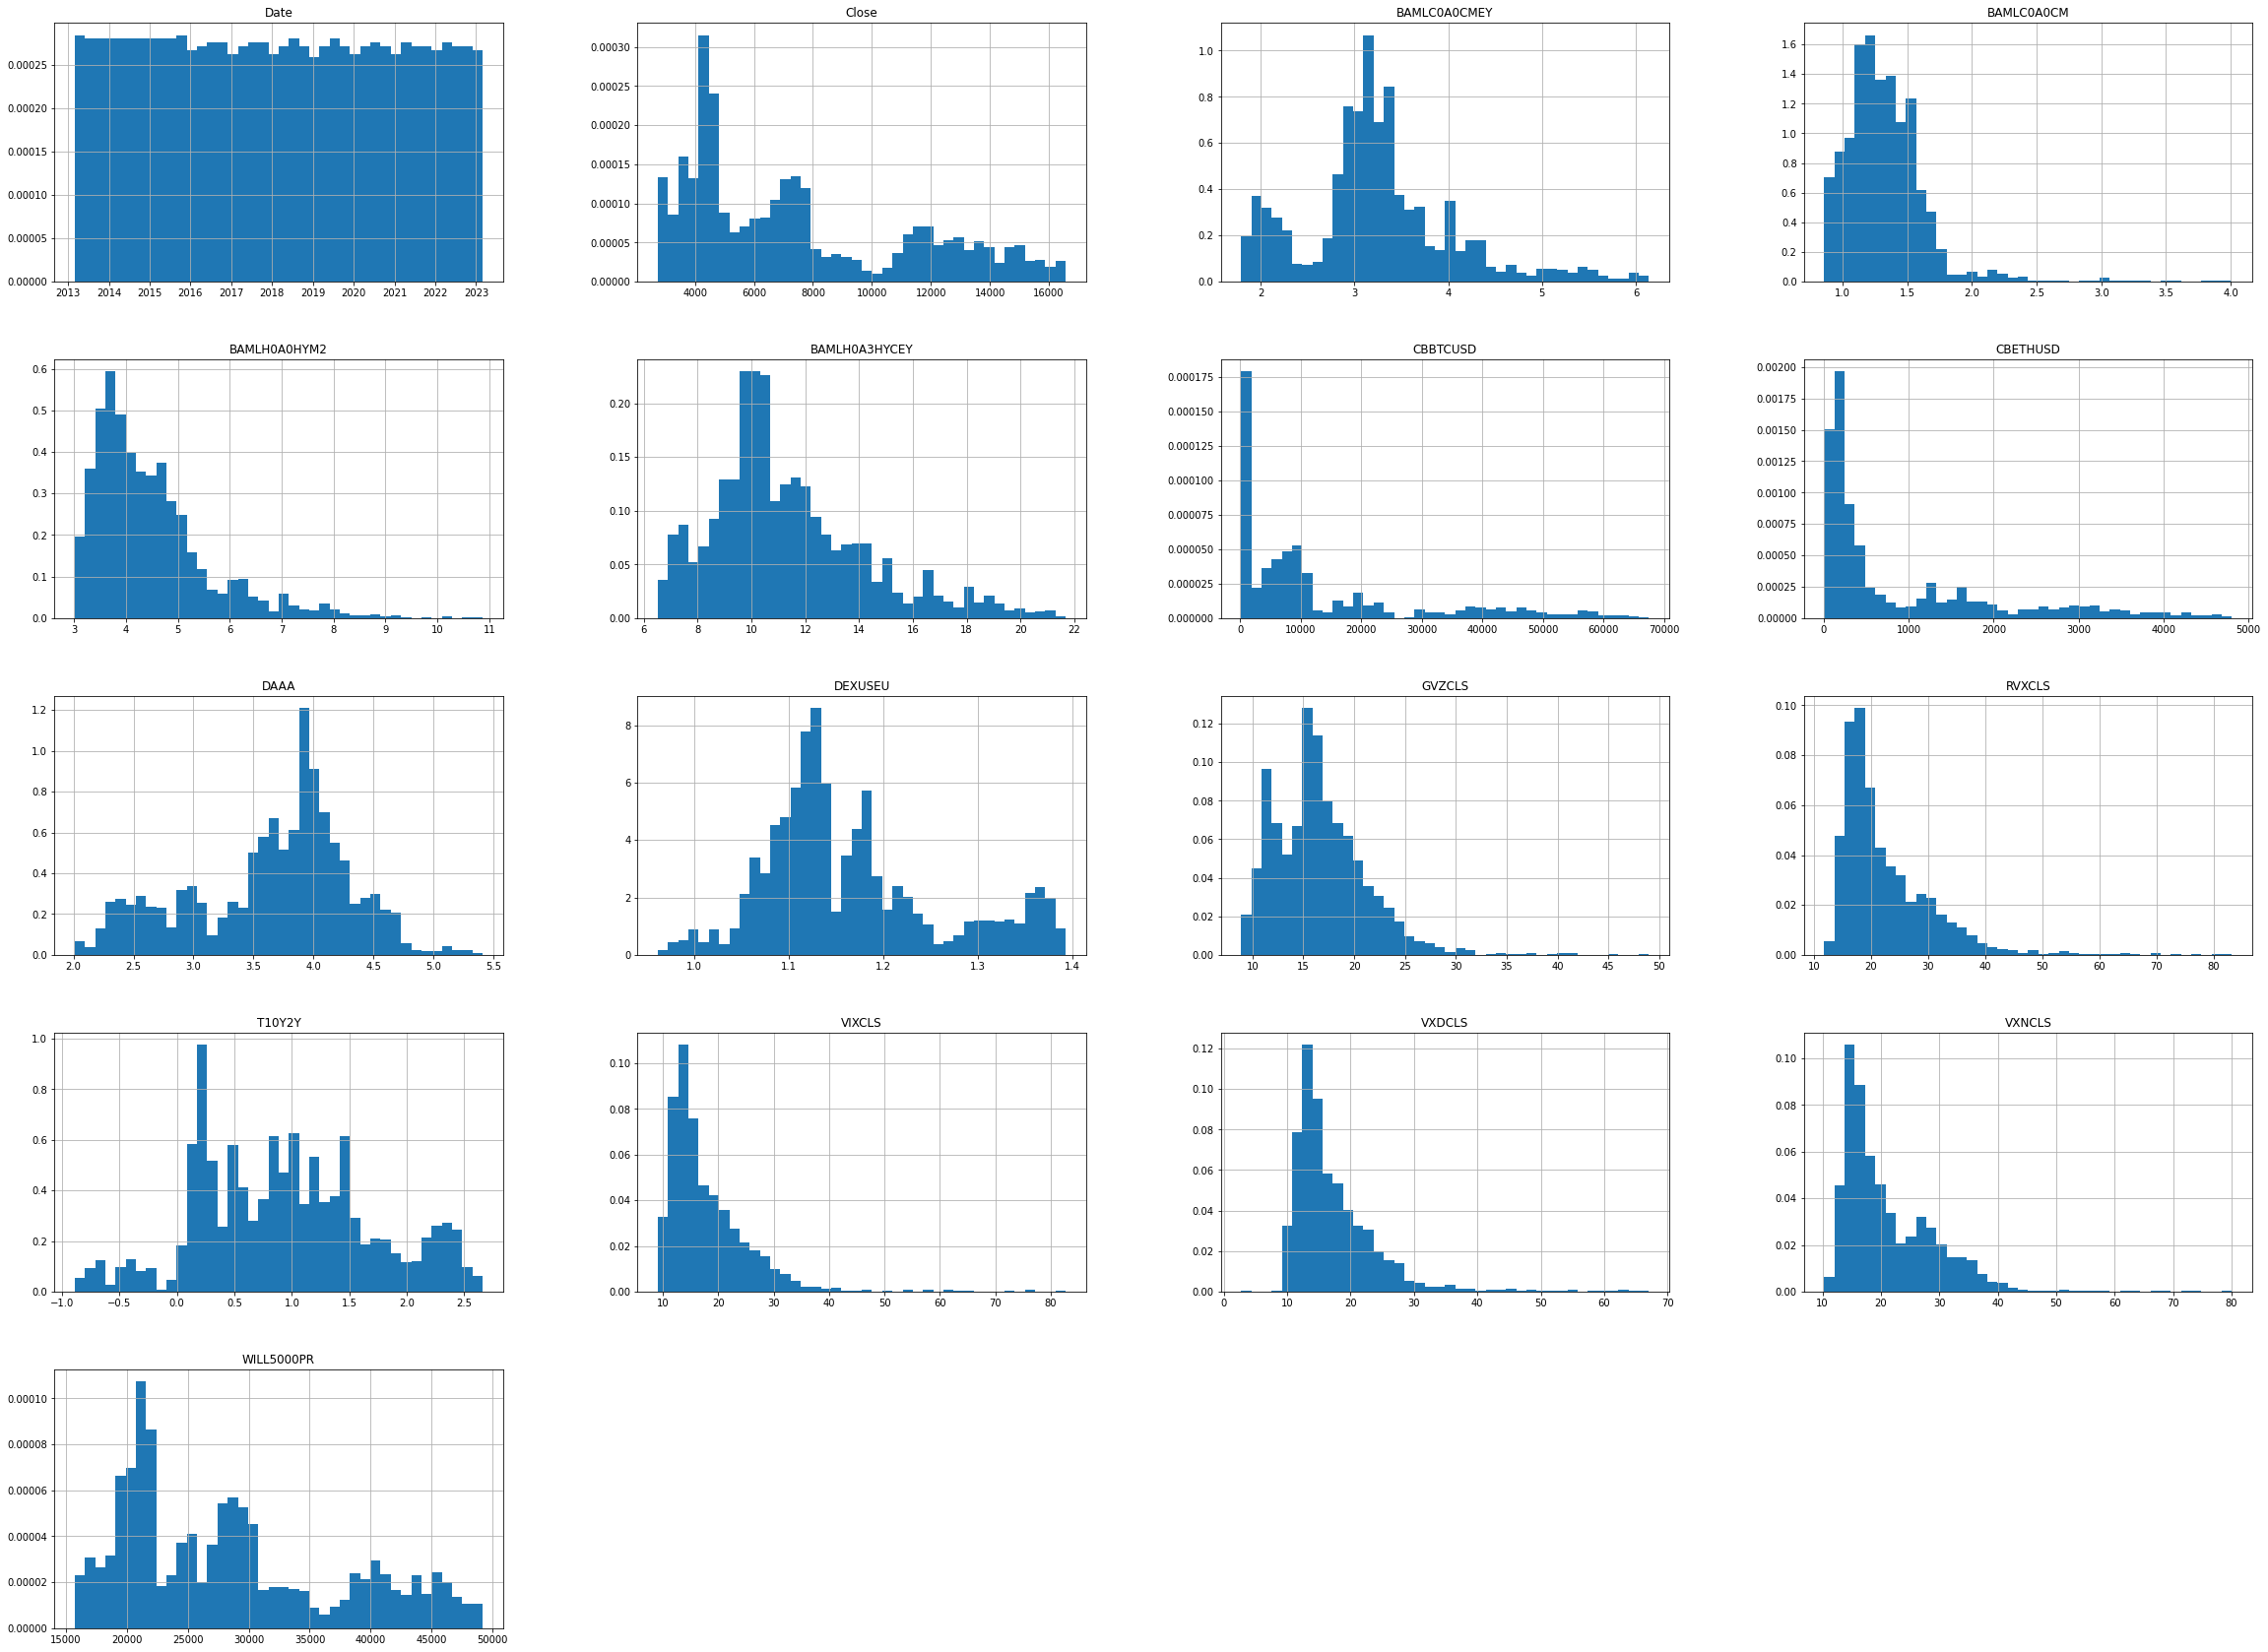

In [14]:
df_agg.hist(figsize=(40,30),bins=40, density=True)

In [15]:
matrix = df_agg.drop(columns=["Date"]).corr()

<AxesSubplot:>

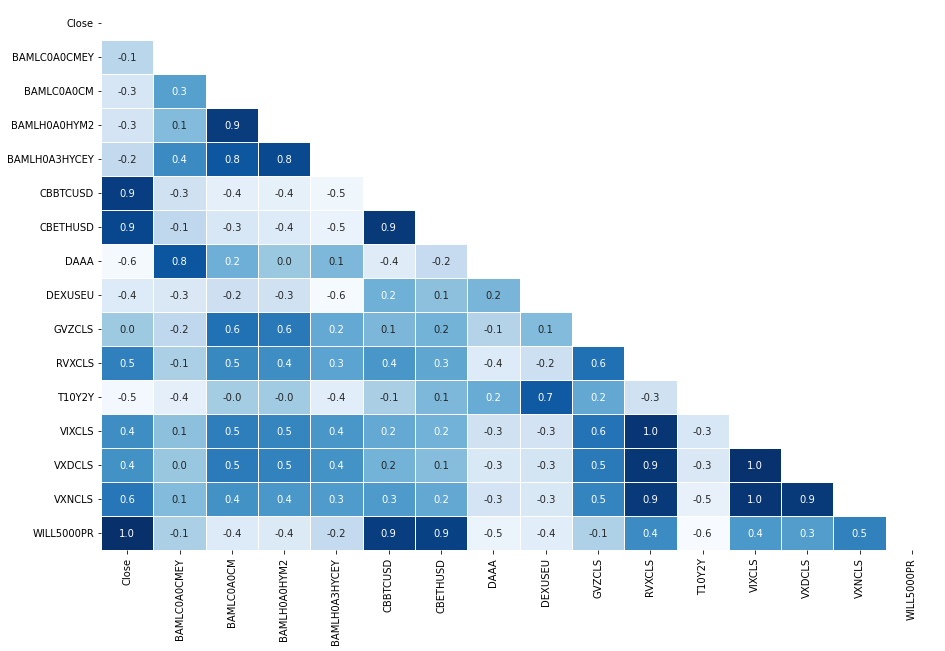

In [16]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [17]:
predictors_df = pps.predictors(df_agg.drop(columns=["Date"]), y='Close')
predictors_df

x      y   ppscore        case  is_valid_score  \
0      WILL5000PR  Close  0.885233  regression            True   
1        CBBTCUSD  Close  0.759053  regression            True   
2        CBETHUSD  Close  0.627278  regression            True   
3    BAMLC0A0CMEY  Close  0.477829  regression            True   
4            DAAA  Close  0.307023  regression            True   
5          T10Y2Y  Close  0.278015  regression            True   
6          RVXCLS  Close  0.240722  regression            True   
7      BAMLC0A0CM  Close  0.197522  regression            True   
8   BAMLH0A3HYCEY  Close  0.194955  regression            True   
9         DEXUSEU  Close  0.169026  regression            True   
10         VXNCLS  Close  0.160476  regression            True   
11   BAMLH0A0HYM2  Close  0.131270  regression            True   
12         VIXCLS  Close  0.096039  regression            True   
13         VXDCLS  Close  0.080863  regression            True   
14         GVZCLS  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error     3071.965301   352.560476  DecisionTreeRegressor()  
1   mean absolute error     2990.117592   720.458786  DecisionTreeRegressor()  
2   mean absolute error     2948.104575  1098.824838  DecisionTreeRegressor()  
3   mean absolute error     3071.965301  1604.092082  DecisionTreeRegressor()  
4   mean absolute error     3071.965301  2128.801525  DecisionTreeRegressor()  
5   mean absolute error     3071.965301  2217.912348  DecisionTreeRegressor()  
6   mean absolute error     3071.965301  2332.474411  DecisionTreeRegressor()  
7   mean absolute error     3071.965301  2465.183635  DecisionTreeRegressor()  
8   mean absolute error     3071.965301  2473.070551  DecisionTreeRegressor()  
9   mean absolute error     3070.033371  2551.118156  DecisionTreeRegressor()  
10  mean absolute error     3071.965301  2578.988411  DecisionTreeRegressor()  
11  mean absolute error     3071.003413  2667.872560  DecisionTreeRegressor()  
12  mean absolute error     3071.965301  2776.937838  DecisionTreeRegressor()  
13  mean absolute error     3071.965301  2823.557432  DecisionTreeRegressor()  
14  mean absolute error     3071.965301  3346.285626  DecisionTreeRegressor()

[Text(0, 0, '0.885233'),
 Text(0, 0, '0.759053'),
 Text(0, 0, '0.627278'),
 Text(0, 0, '0.477829'),
 Text(0, 0, '0.307023'),
 Text(0, 0, '0.278015'),
 Text(0, 0, '0.240722'),
 Text(0, 0, '0.197522'),
 Text(0, 0, '0.194955'),
 Text(0, 0, '0.169026'),
 Text(0, 0, '0.160476'),
 Text(0, 0, '0.13127'),
 Text(0, 0, '0.0960387'),
 Text(0, 0, '0.0808628'),
 Text(0, 0, '0')]

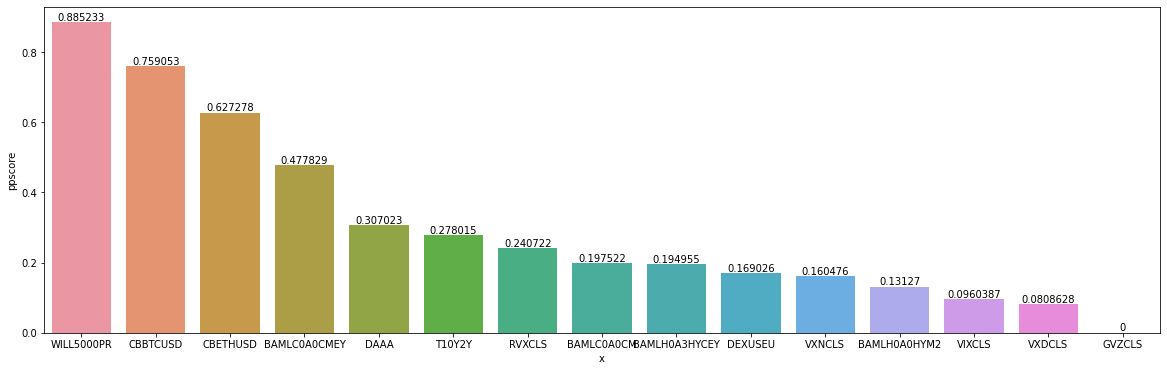

In [18]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

## Données normalisées
On va étudier ici les variations en % par rapport au résultat de la veille, plutôt que les valeurs brutes, puis en Ln, et enfin converti en base 1000

### En %

In [19]:
def daily_var(df):
  ''' variation par rapport à la valeur de la veille, en %'''

  df_dailyR = df.copy()
  col_list = df_dailyR.columns[1:]

  for col in col_list:
    df_dailyR[col] = round( ((df_dailyR[col] - df_dailyR[col].shift(1))/df_dailyR[col].shift(1))*100, 2)
  
  return df_dailyR

In [20]:
df_norm = daily_var(df_agg)
df_norm.dropna(subset=['Close'], inplace=True)
df_norm.reset_index(drop=True, inplace=True)
df_norm.head()

Date  Close  BAMLC0A0CMEY  BAMLC0A0CM  BAMLH0A0HYM2  BAMLH0A3HYCEY  \
0 2013-03-04   0.43          0.36        0.00         -0.40          -0.10   
1 2013-03-05   1.44          0.00       -0.67         -1.20          -0.83   
2 2013-03-06  -0.24          1.07       -0.68         -0.81          -0.31   
3 2013-03-07   0.25          1.06       -0.68         -1.43          -0.42   
4 2013-03-08   0.17          1.05       -0.68         -1.04          -0.11   

   CBBTCUSD  CBETHUSD  DAAA  DEXUSEU  GVZCLS  RVXCLS  T10Y2Y  VIXCLS  VXDCLS  \
0       NaN       NaN  0.52     0.06    1.78   -2.02    1.86   -8.79   -6.17   
1       NaN       NaN  0.52     0.18   -3.49   -6.35    0.61   -3.78   -3.05   
2       NaN       NaN  1.03    -0.22   -2.71   -1.01    3.03    0.37    0.48   
3       NaN       NaN  1.28     0.83   -1.40   -3.06    2.94   -3.47   -3.22   
4       NaN       NaN  1.52    -0.81   -8.76   -4.58    2.29   -3.60   -3.32   

   VXNCLS  WILL5000PR  
0   -1.60        0.44  
1   -5.13        0.98  
2    0.00        0.13  
3   -2.53        0.24  
4   -3.58        0.49

In [21]:
df_norm.describe()

Close  BAMLC0A0CMEY   BAMLC0A0CM  BAMLH0A0HYM2  BAMLH0A3HYCEY  \
count  2540.000000   2540.000000  2540.000000   2539.000000    2540.000000   
mean      0.067323      0.035331     0.003752      0.012627       0.022531   
std       1.345748      1.285340     1.371054      1.987062       1.158287   
min     -12.190000     -7.370000    -7.770000     -9.650000      -9.080000   
25%      -0.460000     -0.670000    -0.720000     -1.050000      -0.510000   
50%       0.110000      0.000000     0.000000     -0.130000      -0.070000   
75%       0.720000      0.670000     0.620000      0.875000       0.470000   
max      10.070000     14.250000    26.170000     18.440000       9.450000   

          CBBTCUSD     CBETHUSD         DAAA      DEXUSEU       GVZCLS  \
count  2084.000000  1706.000000  2540.000000  2538.000000  2540.000000   
mean      0.318748     0.506835     0.019976    -0.006998     0.131185   
std       4.879063     6.777596     1.520740     0.488946     5.323543   
min     -53.850000   -43.090000   -13.350000    -2.640000   -23.330000   
25%      -1.560000    -2.665000    -0.800000    -0.270000    -2.940000   
50%       0.190000     0.065000     0.000000    -0.010000    -0.420000   
75%       2.132500     3.430000     0.780000     0.260000     2.432500   
max      70.180000    49.170000    18.060000     3.110000    61.730000   

            RVXCLS   T10Y2Y       VIXCLS       VXDCLS       VXNCLS  \
count  2540.000000  2539.00  2540.000000  2540.000000  2540.000000   
mean      0.205339      NaN     0.338622     0.426823     0.246449   
std       6.391709      NaN     8.480112    12.071696     6.912945   
min     -30.530000     -inf   -25.910000   -81.760000   -23.570000   
25%      -3.512500    -2.21    -4.322500    -3.842500    -3.690000   
50%      -0.350000     0.00    -0.695000    -0.510000    -0.480000   
75%       2.970000     2.08     3.640000     3.240000     3.200000   
max      71.680000      inf   115.600000   472.320000    59.830000   

        WILL5000PR  
count  2540.000000  
mean      0.043543  
std       1.120965  
min     -12.290000  
25%      -0.380000  
50%       0.070000  
75%       0.540000  
max       9.400000

In [22]:
# Group all data returns together in a list
# Make a copy of the daily returns dataframe
df_hist = df_norm.copy()
df_hist.drop(columns=['Date','T10Y2Y'],inplace=True)
df_hist.dropna(inplace=True)

l_hist=[]
[l_hist.append(df_hist[i].values) for i in df_hist.columns]
len(l_hist)

# Plotly's Python API contains a super pwerful module known as figure factory module 
fig = ff.create_distplot(l_hist, df_hist.columns)
fig.show()

In [23]:
matrix_norm = df_norm.drop(columns=["Date"]).corr()

<AxesSubplot:>

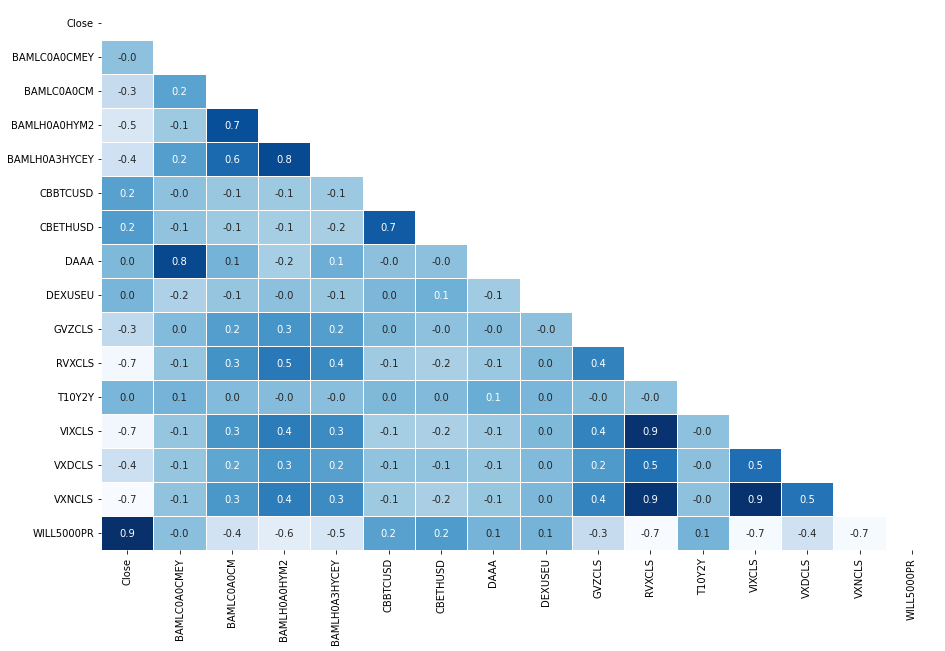

In [24]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_norm, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_norm, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [25]:
predictors_df_norm = pps.predictors(df_norm.drop(columns=["Date","T10Y2Y"]), y='Close')
predictors_df_norm

x      y   ppscore        case  is_valid_score  \
0      WILL5000PR  Close  0.544101  regression            True   
1          VXNCLS  Close  0.066054  regression            True   
2          VIXCLS  Close  0.018467  regression            True   
3    BAMLC0A0CMEY  Close  0.000000  regression            True   
4      BAMLC0A0CM  Close  0.000000  regression            True   
5    BAMLH0A0HYM2  Close  0.000000  regression            True   
6   BAMLH0A3HYCEY  Close  0.000000  regression            True   
7        CBBTCUSD  Close  0.000000  regression            True   
8        CBETHUSD  Close  0.000000  regression            True   
9            DAAA  Close  0.000000  regression            True   
10        DEXUSEU  Close  0.000000  regression            True   
11         GVZCLS  Close  0.000000  regression            True   
12         RVXCLS  Close  0.000000  regression            True   
13         VXDCLS  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error        0.906189     0.413131  DecisionTreeRegressor()  
1   mean absolute error        0.906189     0.846331  DecisionTreeRegressor()  
2   mean absolute error        0.906189     0.889454  DecisionTreeRegressor()  
3   mean absolute error        0.906189     1.080714  DecisionTreeRegressor()  
4   mean absolute error        0.906189     1.007325  DecisionTreeRegressor()  
5   mean absolute error        0.906451     1.030990  DecisionTreeRegressor()  
6   mean absolute error        0.906189     1.010393  DecisionTreeRegressor()  
7   mean absolute error        0.973234     1.347340  DecisionTreeRegressor()  
8   mean absolute error        1.005311     1.406600  DecisionTreeRegressor()  
9   mean absolute error        0.906189     1.112051  DecisionTreeRegressor()  
10  mean absolute error        0.906560     1.030991  DecisionTreeRegressor()  
11  mean absolute error        0.906189     1.221726  DecisionTreeRegressor()  
12  mean absolute error        0.906189     0.923356  DecisionTreeRegressor()  
13  mean absolute error        0.906189     0.991735  DecisionTreeRegressor()

[Text(0, 0, '0.544101'),
 Text(0, 0, '0.0660541'),
 Text(0, 0, '0.018467'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

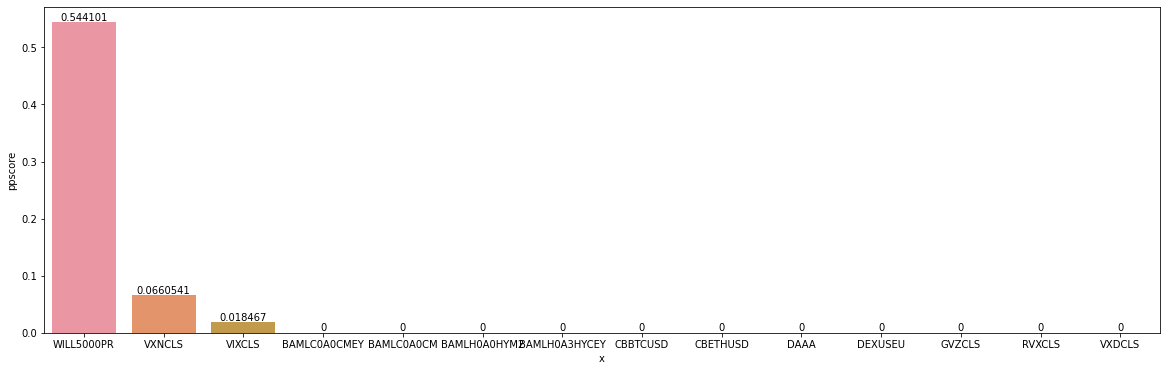

In [26]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_norm, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### En Ln (résulats identiques à %)

In [27]:
def daily_var_ln(df):
  ''' variation par rapport à la valeur de la veille, en %'''

  df_dailyR = df.copy()
  col_list = df_dailyR.columns[1:]

  for col in col_list:
    df_dailyR[col] = round( np.log(df_dailyR[col]/df_dailyR[col].shift(1)), 2)
  
  return df_dailyR

In [28]:
df_Ln = daily_var(df_agg)
df_Ln.dropna(subset=['Close'], inplace=True)
df_Ln.reset_index(drop=True, inplace=True)
df_Ln.head()

Date  Close  BAMLC0A0CMEY  BAMLC0A0CM  BAMLH0A0HYM2  BAMLH0A3HYCEY  \
0 2013-03-04   0.43          0.36        0.00         -0.40          -0.10   
1 2013-03-05   1.44          0.00       -0.67         -1.20          -0.83   
2 2013-03-06  -0.24          1.07       -0.68         -0.81          -0.31   
3 2013-03-07   0.25          1.06       -0.68         -1.43          -0.42   
4 2013-03-08   0.17          1.05       -0.68         -1.04          -0.11   

   CBBTCUSD  CBETHUSD  DAAA  DEXUSEU  GVZCLS  RVXCLS  T10Y2Y  VIXCLS  VXDCLS  \
0       NaN       NaN  0.52     0.06    1.78   -2.02    1.86   -8.79   -6.17   
1       NaN       NaN  0.52     0.18   -3.49   -6.35    0.61   -3.78   -3.05   
2       NaN       NaN  1.03    -0.22   -2.71   -1.01    3.03    0.37    0.48   
3       NaN       NaN  1.28     0.83   -1.40   -3.06    2.94   -3.47   -3.22   
4       NaN       NaN  1.52    -0.81   -8.76   -4.58    2.29   -3.60   -3.32   

   VXNCLS  WILL5000PR  
0   -1.60        0.44  
1   -5.13        0.98  
2    0.00        0.13  
3   -2.53        0.24  
4   -3.58        0.49

In [29]:
# Group all data returns together in a list
# Make a copy of the daily returns dataframe
df_hist = df_Ln.copy()
df_hist.drop(columns=['Date','T10Y2Y'],inplace=True)
df_hist.dropna(inplace=True)

l_hist=[]
[l_hist.append(df_hist[i].values) for i in df_hist.columns]
len(l_hist)

# Plotly's Python API contains a super pwerful module known as figure factory module 
fig = ff.create_distplot(l_hist, df_hist.columns)
fig.show()

In [30]:
matrix_Ln = df_Ln.drop(columns=["Date"]).corr()

<AxesSubplot:>

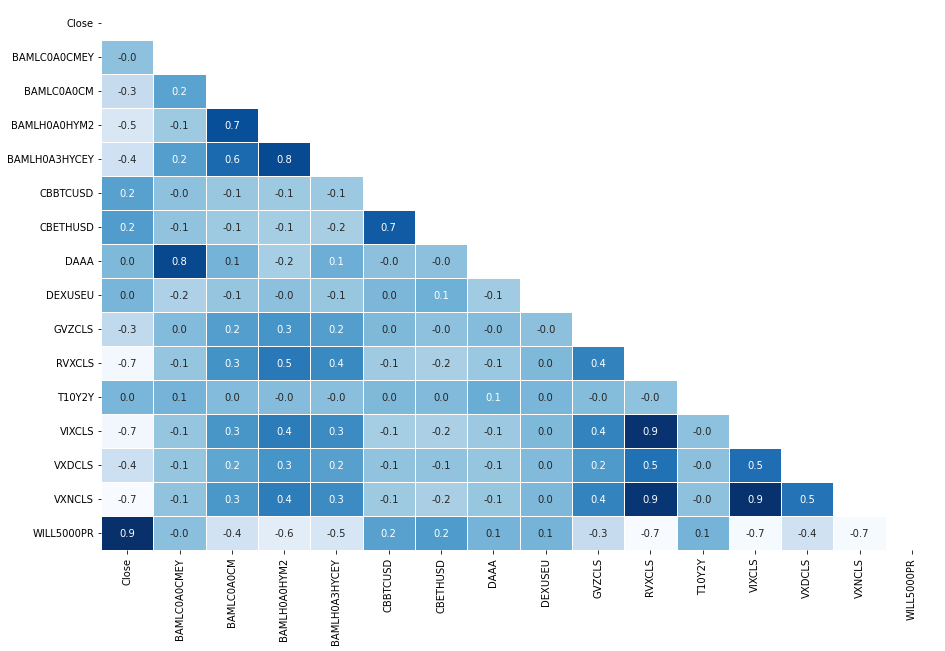

In [31]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_Ln, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_Ln, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [32]:
predictors_df_Ln = pps.predictors(df_Ln.drop(columns=["Date","T10Y2Y"]), y='Close')
predictors_df_Ln

x      y   ppscore        case  is_valid_score  \
0      WILL5000PR  Close  0.544101  regression            True   
1          VXNCLS  Close  0.066054  regression            True   
2          VIXCLS  Close  0.018467  regression            True   
3    BAMLC0A0CMEY  Close  0.000000  regression            True   
4      BAMLC0A0CM  Close  0.000000  regression            True   
5    BAMLH0A0HYM2  Close  0.000000  regression            True   
6   BAMLH0A3HYCEY  Close  0.000000  regression            True   
7        CBBTCUSD  Close  0.000000  regression            True   
8        CBETHUSD  Close  0.000000  regression            True   
9            DAAA  Close  0.000000  regression            True   
10        DEXUSEU  Close  0.000000  regression            True   
11         GVZCLS  Close  0.000000  regression            True   
12         RVXCLS  Close  0.000000  regression            True   
13         VXDCLS  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error        0.906189     0.413131  DecisionTreeRegressor()  
1   mean absolute error        0.906189     0.846331  DecisionTreeRegressor()  
2   mean absolute error        0.906189     0.889454  DecisionTreeRegressor()  
3   mean absolute error        0.906189     1.080714  DecisionTreeRegressor()  
4   mean absolute error        0.906189     1.007325  DecisionTreeRegressor()  
5   mean absolute error        0.906451     1.030990  DecisionTreeRegressor()  
6   mean absolute error        0.906189     1.010393  DecisionTreeRegressor()  
7   mean absolute error        0.973234     1.347340  DecisionTreeRegressor()  
8   mean absolute error        1.005311     1.406600  DecisionTreeRegressor()  
9   mean absolute error        0.906189     1.112051  DecisionTreeRegressor()  
10  mean absolute error        0.906560     1.030991  DecisionTreeRegressor()  
11  mean absolute error        0.906189     1.221726  DecisionTreeRegressor()  
12  mean absolute error        0.906189     0.923356  DecisionTreeRegressor()  
13  mean absolute error        0.906189     0.991735  DecisionTreeRegressor()

[Text(0, 0, '0.544101'),
 Text(0, 0, '0.0660541'),
 Text(0, 0, '0.018467'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

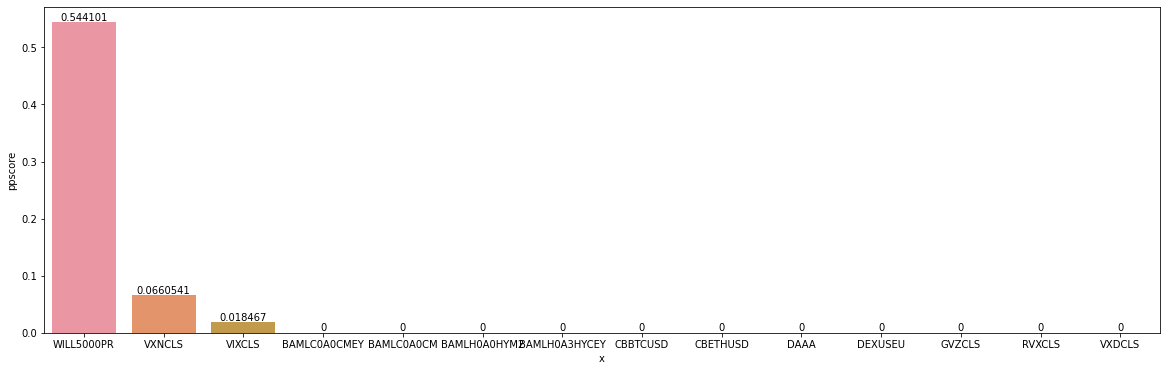

In [33]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_Ln, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### En base 1000

In [34]:
# Fonction pour normaliser les valeurs base 1000
def normalize(df):
  df_norm = df.copy()
  col_list = df.columns
  for element in col_list[1:]:
    df_norm[element] = df_norm[element].apply(lambda x: (x/(df_norm.loc[0,element])*1000))
  return df_norm

In [35]:
# Fonction de visualisation avec Plotly
def interactif_plot(df, titre):
  fig = px.line(title = titre)

  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name =i)

  fig.show()

In [36]:
df_base1000 = df_agg.dropna()
df_base1000.reset_index(drop=True, inplace=True)

In [37]:
df_base1000 = normalize(df_base1000)
interactif_plot(df_base1000,'Variation base 1000')

In [38]:
matrix_1000 = df_base1000.drop(columns=["Date"]).corr()

<AxesSubplot:>

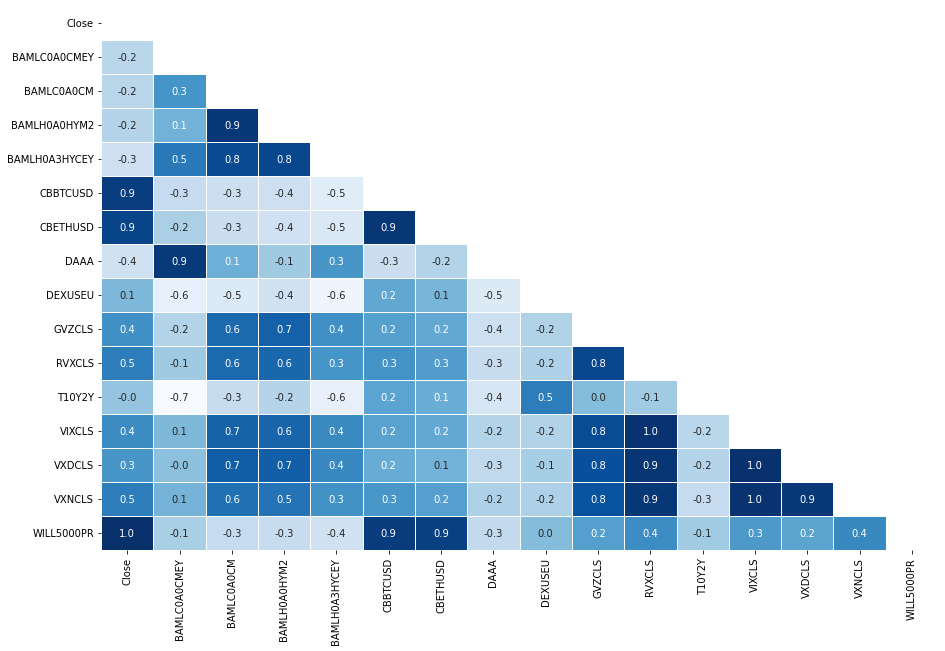

In [39]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_1000, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_1000, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

Les correlations sont vérifiées et globalement pour celles >=0.5, incrémentées de +- 0.1/0.2, converti en base 1000

In [40]:
predictors_df_base1000 = pps.predictors(df_base1000.drop(columns=["Date"]), y='Close')
predictors_df_base1000

x      y   ppscore        case  is_valid_score  \
0      WILL5000PR  Close  0.851628  regression            True   
1        CBBTCUSD  Close  0.709756  regression            True   
2        CBETHUSD  Close  0.631983  regression            True   
3    BAMLC0A0CMEY  Close  0.482801  regression            True   
4   BAMLH0A3HYCEY  Close  0.346310  regression            True   
5          RVXCLS  Close  0.340857  regression            True   
6            DAAA  Close  0.338299  regression            True   
7          T10Y2Y  Close  0.230159  regression            True   
8          VIXCLS  Close  0.217313  regression            True   
9      BAMLC0A0CM  Close  0.217204  regression            True   
10         VXNCLS  Close  0.204273  regression            True   
11   BAMLH0A0HYM2  Close  0.164702  regression            True   
12         GVZCLS  Close  0.151614  regression            True   
13         VXDCLS  Close  0.145344  regression            True   
14        DEXUSEU  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error      679.231256   100.778851  DecisionTreeRegressor()  
1   mean absolute error      679.231256   197.142841  DecisionTreeRegressor()  
2   mean absolute error      679.231256   249.968396  DecisionTreeRegressor()  
3   mean absolute error      679.231256   351.297928  DecisionTreeRegressor()  
4   mean absolute error      679.231256   444.006660  DecisionTreeRegressor()  
5   mean absolute error      679.231256   447.710803  DecisionTreeRegressor()  
6   mean absolute error      679.231256   449.448245  DecisionTreeRegressor()  
7   mean absolute error      679.231256   522.900061  DecisionTreeRegressor()  
8   mean absolute error      679.231256   531.625785  DecisionTreeRegressor()  
9   mean absolute error      679.231256   531.699405  DecisionTreeRegressor()  
10  mean absolute error      679.231256   540.482552  DecisionTreeRegressor()  
11  mean absolute error      679.231256   567.360749  DecisionTreeRegressor()  
12  mean absolute error      679.231256   576.250334  DecisionTreeRegressor()  
13  mean absolute error      679.231256   580.508903  DecisionTreeRegressor()  
14  mean absolute error      679.231256   695.193611  DecisionTreeRegressor()

[Text(0, 0, '0.851628'),
 Text(0, 0, '0.709756'),
 Text(0, 0, '0.631983'),
 Text(0, 0, '0.482801'),
 Text(0, 0, '0.34631'),
 Text(0, 0, '0.340857'),
 Text(0, 0, '0.338299'),
 Text(0, 0, '0.230159'),
 Text(0, 0, '0.217313'),
 Text(0, 0, '0.217204'),
 Text(0, 0, '0.204273'),
 Text(0, 0, '0.164702'),
 Text(0, 0, '0.151614'),
 Text(0, 0, '0.145344'),
 Text(0, 0, '0')]

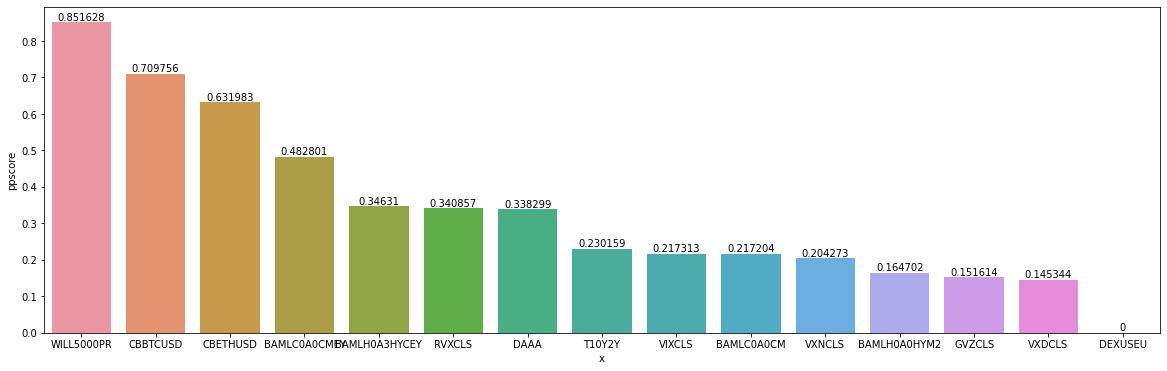

In [41]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_base1000, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

Ici le résultat est globalement identique pour le Top 4, comparativement entre base 1000 et mesures brutes.<br>
Toutefois l'ordre change pour les valeurs autour de 0.3 (seuil bas, peut-être à ne même pas prendre en considération)

Les valeurs normalisées semblent avoir un pps < aux données brutes ?<br>
Bien vérifier par la suite avec les Lags

# BTC, ETH & WILL5000 shift

## ACF, PACF

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [43]:
df_shifted = df_norm[['Date','Close','CBBTCUSD','CBETHUSD','WILL5000PR']]
df_shifted.dropna(inplace=True)
df_shifted.reset_index(drop=True, inplace=True)

In [44]:
df_shifted.head(1)

Date  Close  CBBTCUSD  CBETHUSD  WILL5000PR
0 2016-05-19  -0.52     -3.77     13.05       -0.39

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



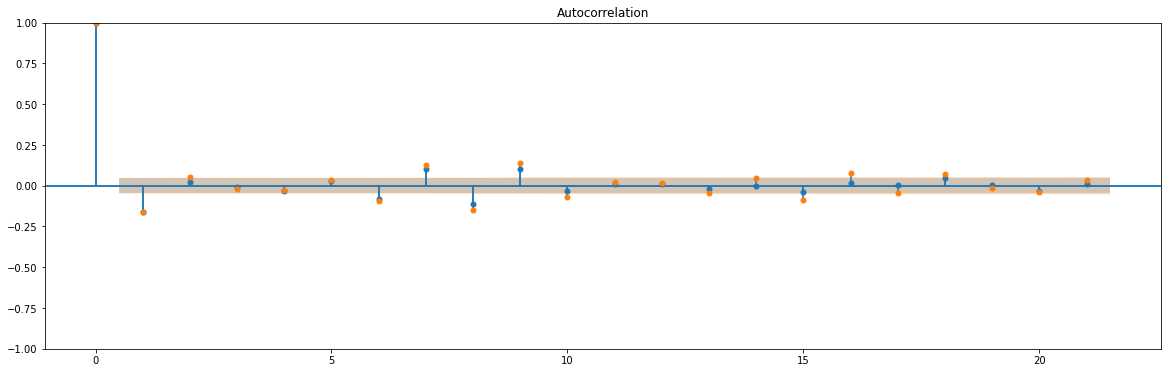

In [45]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["Close"], lags=21, ax=ax)
plot_acf(df_shifted["Close"], lags=21, ax=ax)
plt.show()

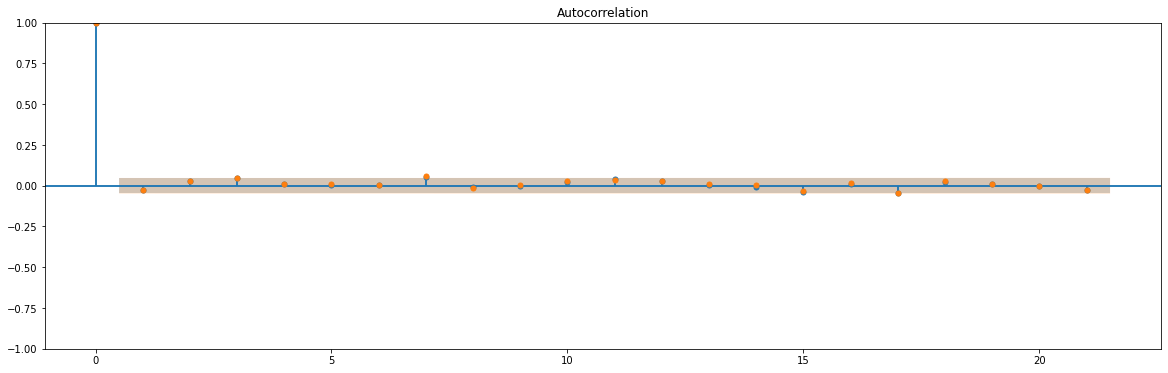

In [46]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["CBBTCUSD"], lags=21, ax=ax)
plot_acf(df_shifted["CBBTCUSD"], lags=21, ax=ax)
plt.show()

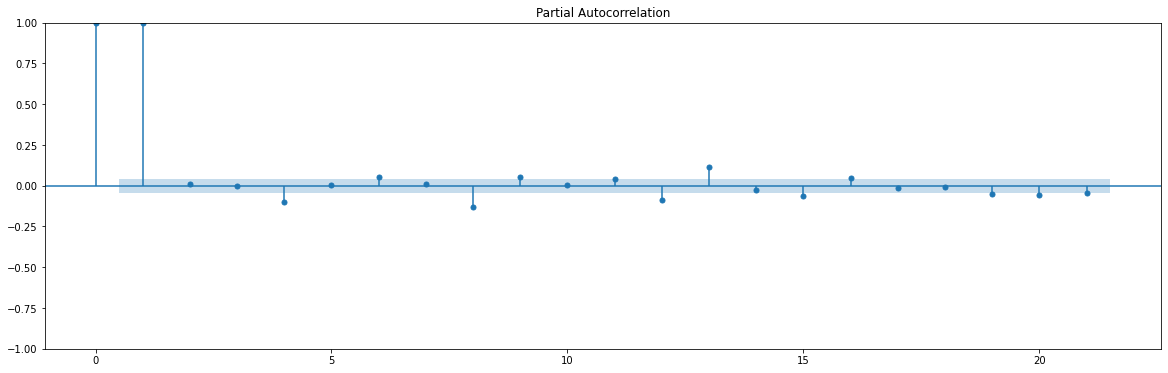

In [47]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_agg["CBBTCUSD"].dropna(), lags=21, ax=ax)
plt.show()

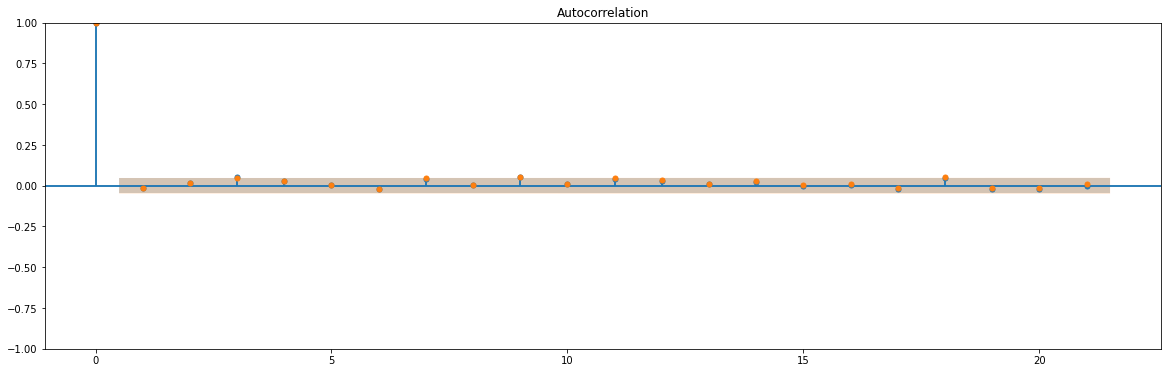

In [48]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["CBETHUSD"], lags=21, ax=ax)
plot_acf(df_shifted["CBETHUSD"], lags=21, ax=ax)
plt.show()

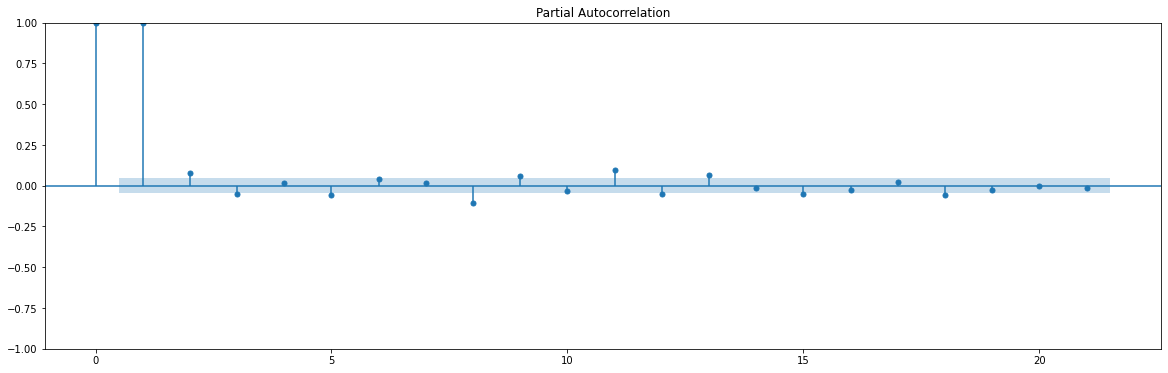

In [49]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_agg["CBETHUSD"].dropna(), lags=21, ax=ax)
plt.show()

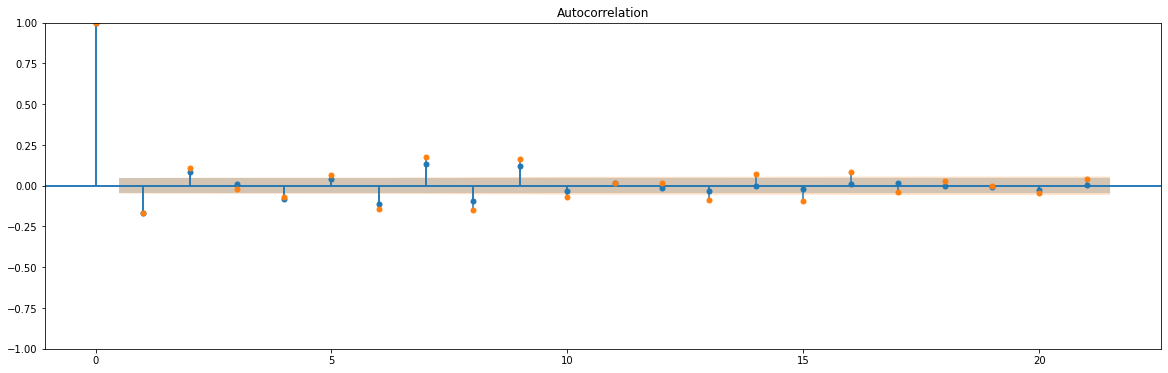

In [50]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["WILL5000PR"], lags=21, ax=ax)
plot_acf(df_shifted["WILL5000PR"], lags=21, ax=ax)
plt.show()

Conclusion :<br>
Pour BTC & ETH (raw) : 1, 8<br>
Pour Close : 1(raw), 2(raw slt) 7, 8(raw), 9, 10(raw slt)<br>
Pour WILL5000PR : 1(raw), 6, 7, 8(raw), 9, 10(raw slt)

## Génération des colonnes identifiées

### Shifted raws

In [51]:
df_shifted_raw = df_agg[['Date','Close','CBBTCUSD','CBETHUSD','WILL5000PR']].copy()
df_shifted_raw.head(1)

Date    Close  CBBTCUSD  CBETHUSD  WILL5000PR
0 2013-03-01  2747.75       NaN       NaN    15738.23

In [52]:
df_shifted_raw["BTC_lag1"] = df_shifted_raw["CBBTCUSD"].shift(1)
df_shifted_raw["ETH_lag1"] = df_shifted_raw["CBETHUSD"].shift(1)
df_shifted_raw["Close_lag1"] = df_shifted_raw["Close"].shift(1)
df_shifted_raw["Will_lag1"] = df_shifted_raw["WILL5000PR"].shift(1)

df_shifted_raw["Close_lag2"] = df_shifted_raw["Close"].shift(2)

df_shifted_raw["BTC_lag8"] = df_shifted_raw["CBBTCUSD"].shift(8)
df_shifted_raw["ETH_lag8"] = df_shifted_raw["CBETHUSD"].shift(8)
df_shifted_raw["Close_lag8"] = df_shifted_raw["Close"].shift(8)
df_shifted_raw["Will_lag8"] = df_shifted_raw["WILL5000PR"].shift(8)

df_shifted_raw["Close_lag10"] = df_shifted_raw["Close"].shift(10)
df_shifted_raw["Will_lag10"] = df_shifted_raw["WILL5000PR"].shift(10)

In [53]:
df_shifted_raw.tail(1)

Date     Close  CBBTCUSD  CBETHUSD  WILL5000PR  BTC_lag1  ETH_lag1  \
2540 2023-02-28  12042.12  23146.93   1605.79    40496.66  23479.61   1633.29   

      Close_lag1  Will_lag1  Close_lag2  BTC_lag8  ETH_lag8  Close_lag8  \
2540    12057.79   40605.89    11969.65  24340.76   1675.52    12687.89   

      Will_lag8  Close_lag10  Will_lag10  
2540   42311.95     12502.31    42098.46

In [54]:
matrix_shifted_raw = df_shifted_raw.drop(columns=["Date","CBBTCUSD","CBETHUSD","WILL5000PR"]).corr()

<AxesSubplot:>

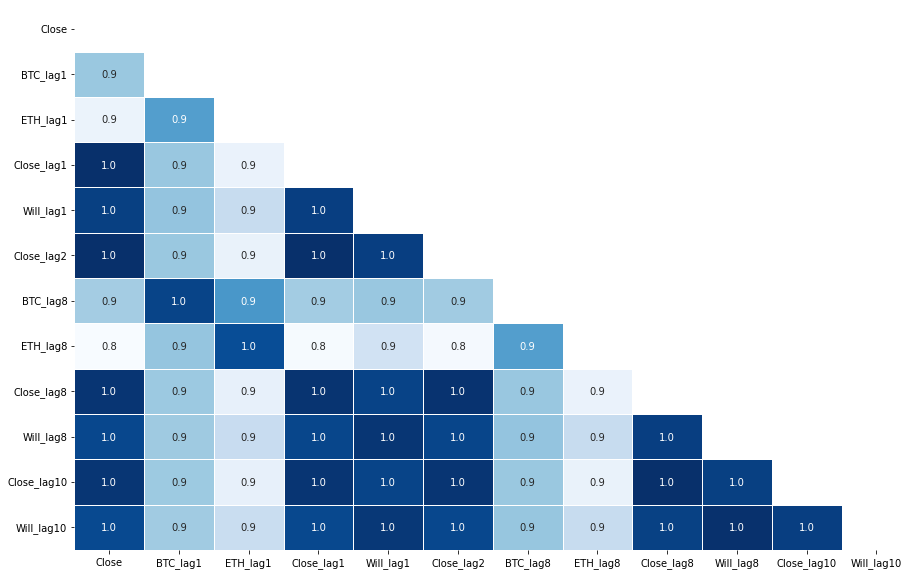

In [55]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_shifted_raw, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_shifted_raw, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

Les correlations sont vérifiées et globalement pour celles >=0.5, incrémentées de +- 0.1/0.2, converti en base 1000

In [56]:
predictors_df_shifted_raw = pps.predictors(df_shifted_raw.drop(columns=["Date","CBBTCUSD","CBETHUSD","WILL5000PR"]), y='Close')
predictors_df_shifted_raw

x      y   ppscore        case  is_valid_score  \
0    Close_lag1  Close  0.963932  regression            True   
1    Close_lag2  Close  0.951126  regression            True   
2    Close_lag8  Close  0.911869  regression            True   
3   Close_lag10  Close  0.902646  regression            True   
4     Will_lag1  Close  0.878883  regression            True   
5     Will_lag8  Close  0.842320  regression            True   
6    Will_lag10  Close  0.831708  regression            True   
7      BTC_lag1  Close  0.758806  regression            True   
8      BTC_lag8  Close  0.740590  regression            True   
9      ETH_lag1  Close  0.622637  regression            True   
10     ETH_lag8  Close  0.601055  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error     3071.686858   110.791122  DecisionTreeRegressor()  
1   mean absolute error     3071.412682   150.112919  DecisionTreeRegressor()  
2   mean absolute error     3069.839684   270.547933  DecisionTreeRegressor()  
3   mean absolute error     3069.302327   298.809963  DecisionTreeRegressor()  
4   mean absolute error     3071.686858   372.033370  DecisionTreeRegressor()  
5   mean absolute error     3069.839684   484.052155  DecisionTreeRegressor()  
6   mean absolute error     3069.302327   516.538367  DecisionTreeRegressor()  
7   mean absolute error     2990.108546   721.195933  DecisionTreeRegressor()  
8   mean absolute error     2990.027217   775.641780  DecisionTreeRegressor()  
9   mean absolute error     2947.759742  1112.374183  DecisionTreeRegressor()  
10  mean absolute error     2945.623508  1175.140925  DecisionTreeRegressor()

[Text(0, 0, '0.963932'),
 Text(0, 0, '0.951126'),
 Text(0, 0, '0.911869'),
 Text(0, 0, '0.902646'),
 Text(0, 0, '0.878883'),
 Text(0, 0, '0.84232'),
 Text(0, 0, '0.831708'),
 Text(0, 0, '0.758806'),
 Text(0, 0, '0.74059'),
 Text(0, 0, '0.622637'),
 Text(0, 0, '0.601055')]

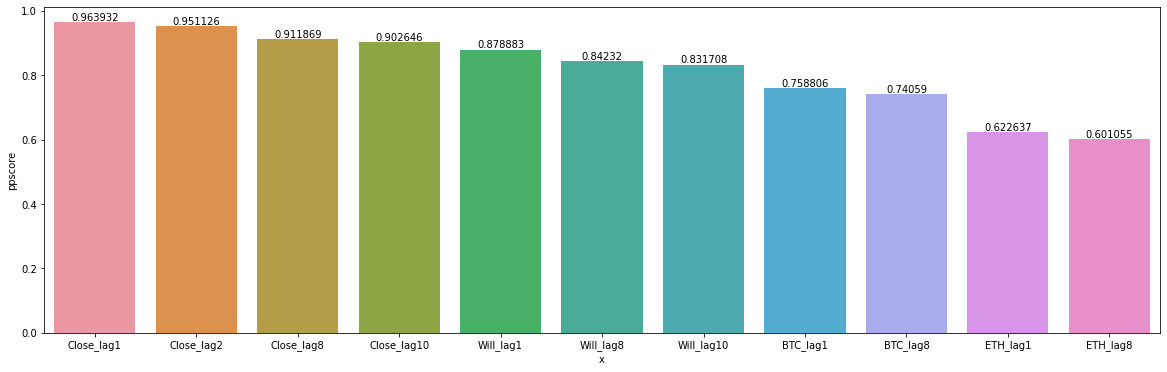

In [57]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_shifted_raw, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### Lags base 1000

array([[<AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'BAMLC0A0CMEY'}>,
        <AxesSubplot:title={'center':'BAMLC0A0CM'}>],
       [<AxesSubplot:title={'center':'BAMLH0A0HYM2'}>,
        <AxesSubplot:title={'center':'BAMLH0A3HYCEY'}>,
        <AxesSubplot:title={'center':'CBBTCUSD'}>,
        <AxesSubplot:title={'center':'CBETHUSD'}>],
       [<AxesSubplot:title={'center':'DAAA'}>,
        <AxesSubplot:title={'center':'DEXUSEU'}>,
        <AxesSubplot:title={'center':'GVZCLS'}>,
        <AxesSubplot:title={'center':'RVXCLS'}>],
       [<AxesSubplot:title={'center':'T10Y2Y'}>,
        <AxesSubplot:title={'center':'VIXCLS'}>,
        <AxesSubplot:title={'center':'VXDCLS'}>,
        <AxesSubplot:title={'center':'VXNCLS'}>],
       [<AxesSubplot:title={'center':'WILL5000PR'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

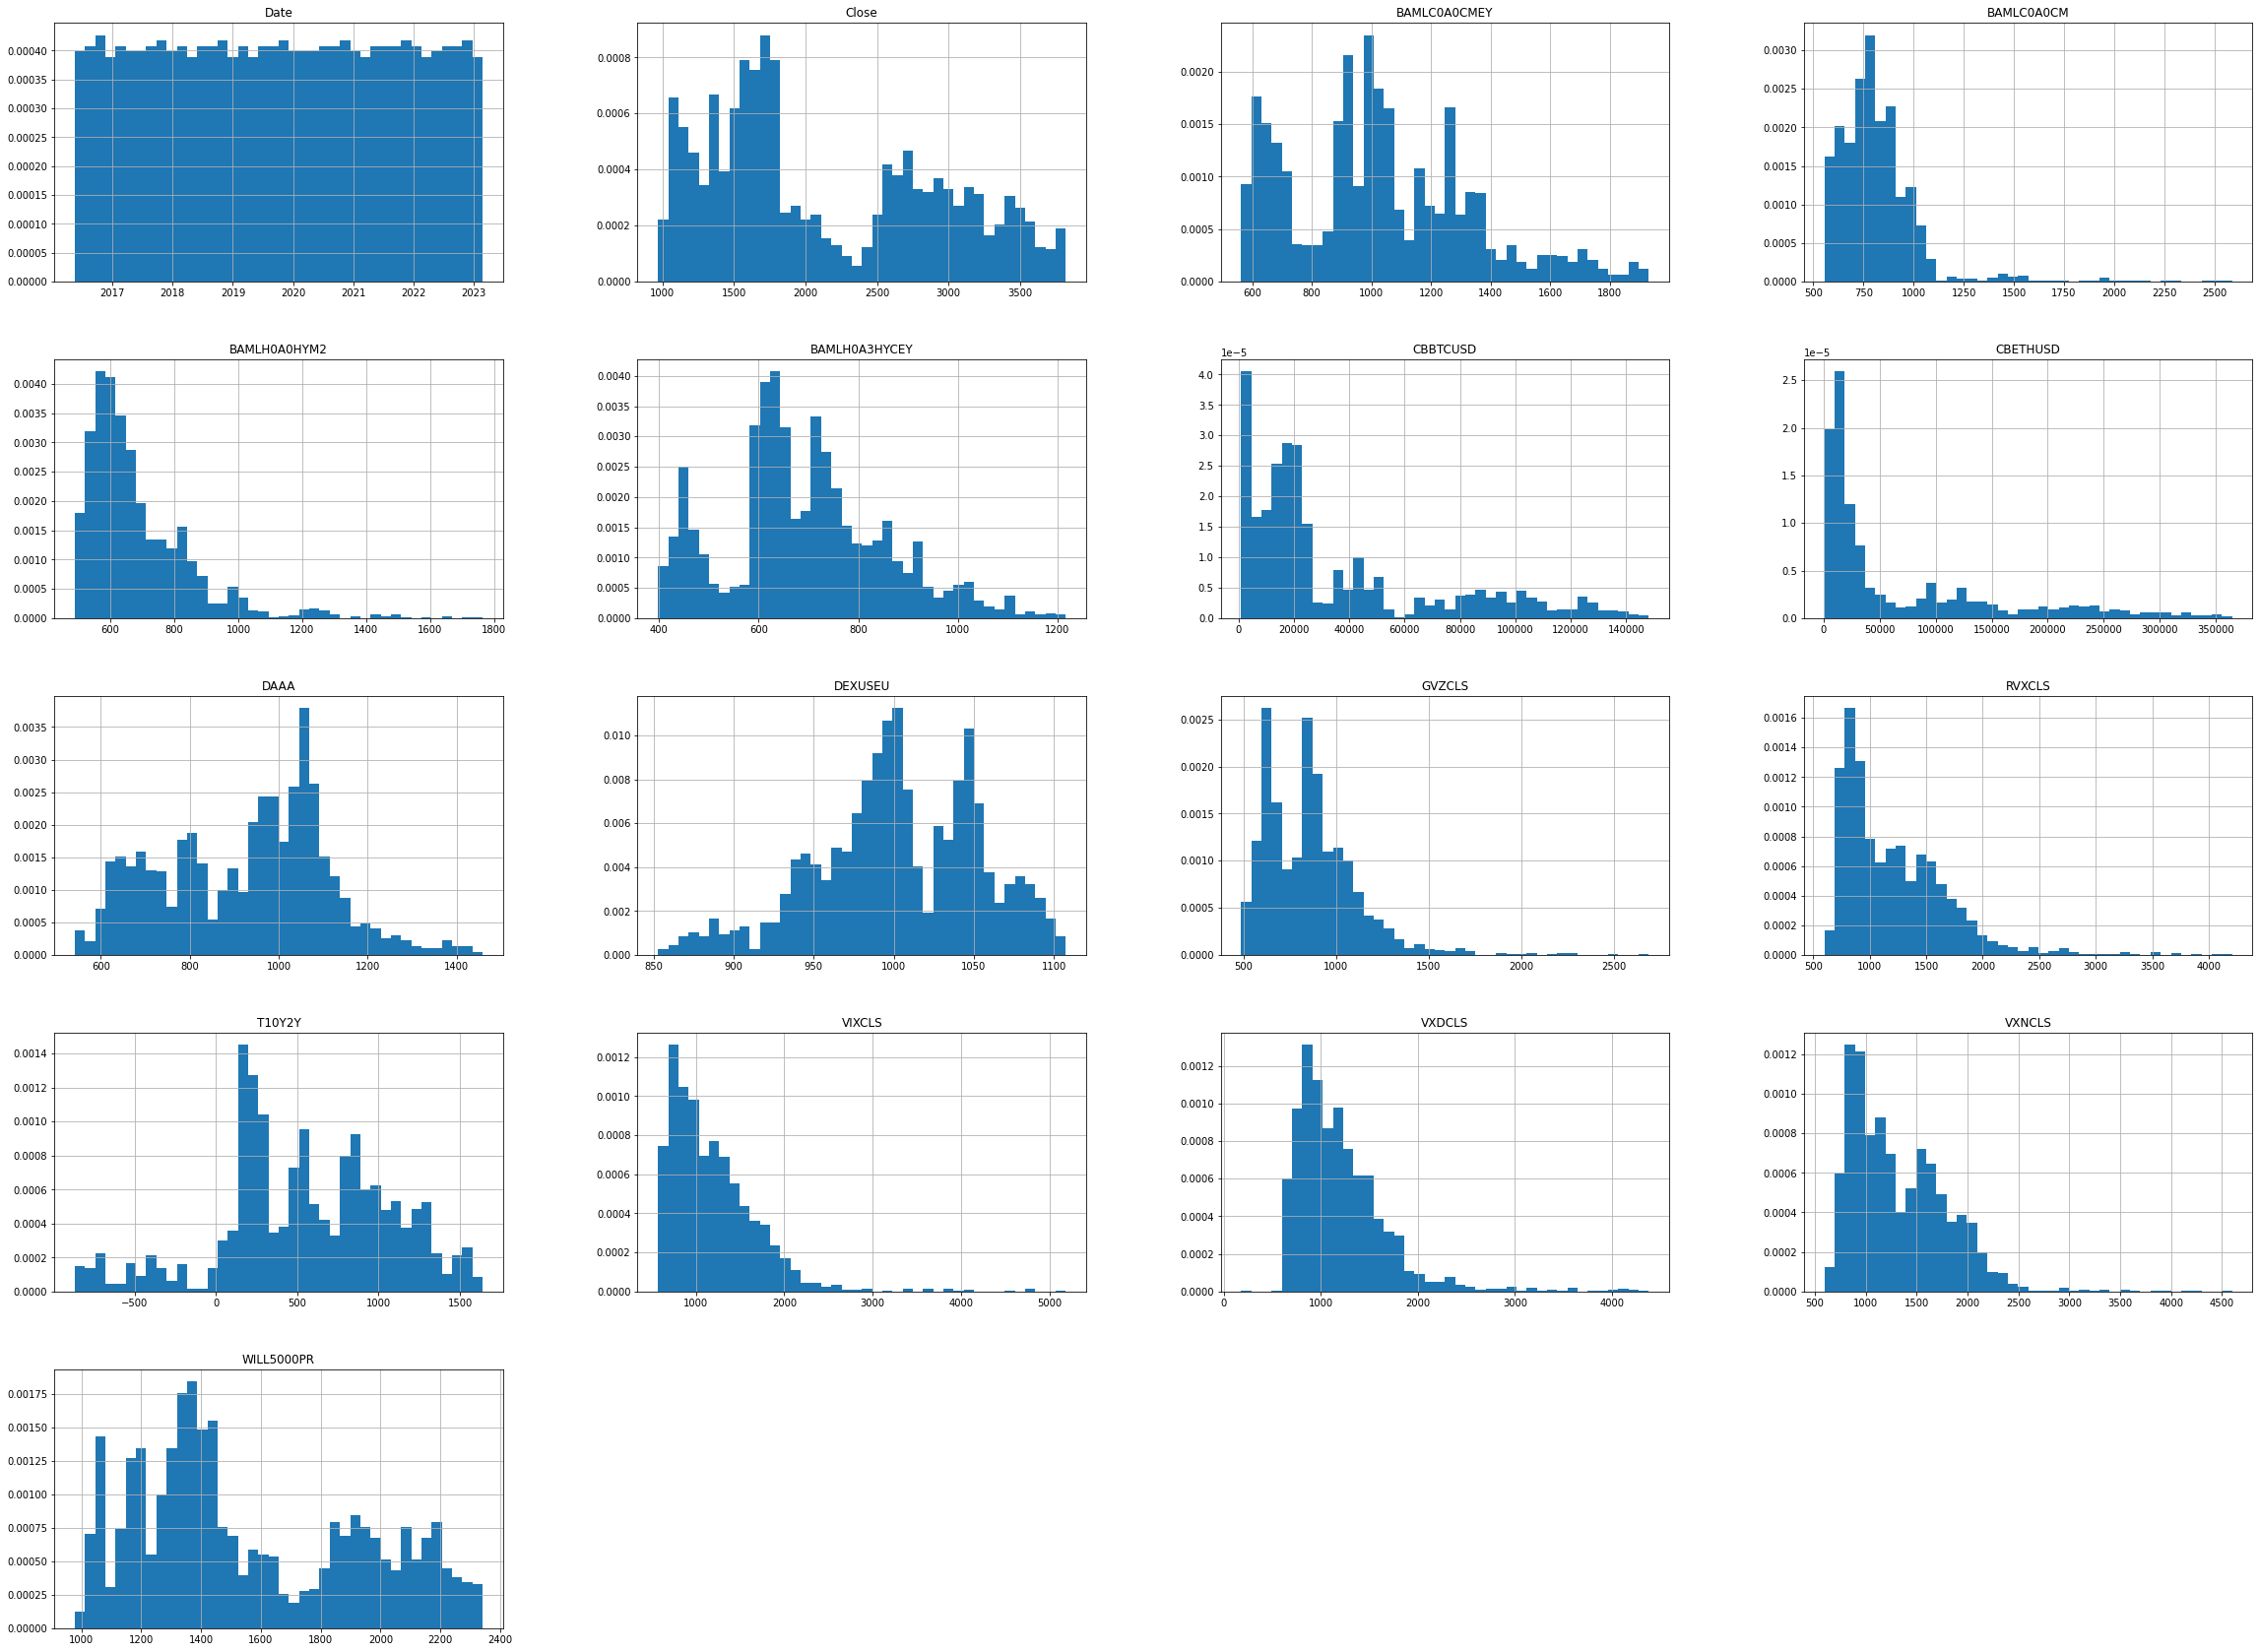

In [58]:
df_base1000.hist(figsize=(40,30),bins=40, density=True)

In [60]:
df_base1000.head(1)

Date   Close  BAMLC0A0CMEY  BAMLC0A0CM  BAMLH0A0HYM2  BAMLH0A3HYCEY  \
0 2016-05-18  1000.0        1000.0      1000.0        1000.0         1000.0   

   CBBTCUSD  CBETHUSD    DAAA  DEXUSEU  GVZCLS  RVXCLS  T10Y2Y  VIXCLS  \
0    1000.0    1000.0  1000.0   1000.0  1000.0  1000.0  1000.0  1000.0   

   VXDCLS  VXNCLS  WILL5000PR  
0  1000.0  1000.0      1000.0

In [61]:
df_base1000["BTC_lag1"] = df_base1000["CBBTCUSD"].shift(1)
df_base1000["ETH_lag1"] = df_base1000["CBETHUSD"].shift(1)
df_base1000["Close_lag1"] = df_base1000["Close"].shift(1)
df_base1000["Will_lag1"] = df_base1000["WILL5000PR"].shift(1)

df_base1000["Close_lag2"] = df_base1000["Close"].shift(2)

df_base1000["BTC_lag8"] = df_base1000["CBBTCUSD"].shift(8)
df_base1000["ETH_lag8"] = df_base1000["CBETHUSD"].shift(8)
df_base1000["Close_lag8"] = df_base1000["Close"].shift(8)
df_base1000["Will_lag8"] = df_base1000["WILL5000PR"].shift(8)

df_base1000["Close_lag10"] = df_base1000["Close"].shift(10)
df_base1000["Will_lag10"] = df_base1000["WILL5000PR"].shift(10)

In [67]:
df_base1000.columns

Index(['Date', 'Close', 'BAMLC0A0CMEY', 'BAMLC0A0CM', 'BAMLH0A0HYM2',
       'BAMLH0A3HYCEY', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'DEXUSEU', 'GVZCLS',
       'RVXCLS', 'T10Y2Y', 'VIXCLS', 'VXDCLS', 'VXNCLS', 'WILL5000PR',
       'BTC_lag1', 'ETH_lag1', 'Close_lag1', 'Will_lag1', 'Close_lag2',
       'BTC_lag8', 'ETH_lag8', 'Close_lag8', 'Will_lag8', 'Close_lag10',
       'Will_lag10'],
      dtype='object')

In [68]:
df_shifted1000 = df_base1000[['Close',
       'BTC_lag1', 'ETH_lag1', 'Close_lag1', 'Will_lag1', 'Close_lag2',
       'BTC_lag8', 'ETH_lag8', 'Close_lag8', 'Will_lag8', 'Close_lag10',
       'Will_lag10']]

In [69]:
matrix_shifted1000_raw = df_shifted1000.corr()

<AxesSubplot:>

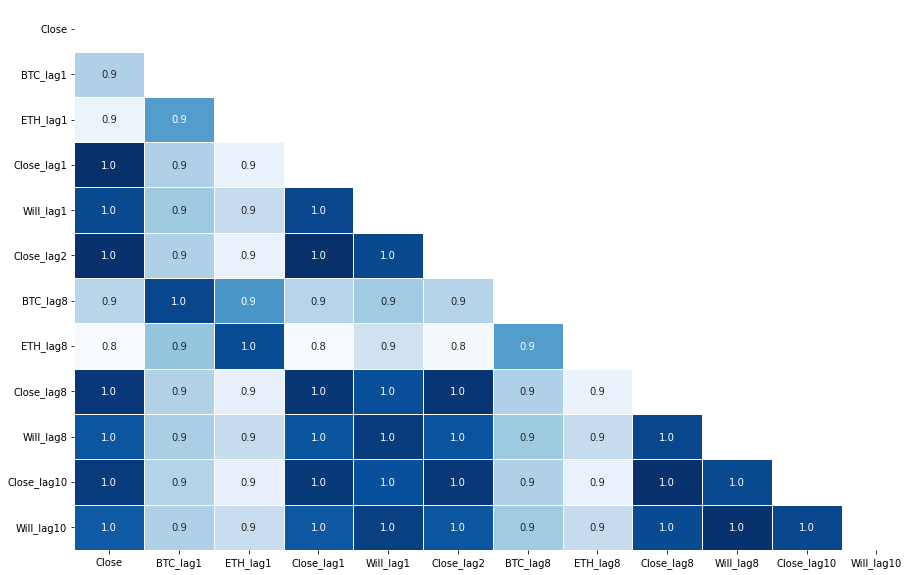

In [70]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_shifted1000_raw, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_shifted1000_raw, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [71]:
predictors_df_shifted1000_raw = pps.predictors(df_shifted1000, y='Close')
predictors_df_shifted1000_raw

x      y   ppscore        case  is_valid_score  \
0    Close_lag1  Close  0.950709  regression            True   
1    Close_lag2  Close  0.933156  regression            True   
2    Close_lag8  Close  0.879495  regression            True   
3   Close_lag10  Close  0.864986  regression            True   
4     Will_lag1  Close  0.840038  regression            True   
5     Will_lag8  Close  0.788766  regression            True   
6    Will_lag10  Close  0.767621  regression            True   
7      BTC_lag1  Close  0.701976  regression            True   
8      BTC_lag8  Close  0.679967  regression            True   
9      ETH_lag1  Close  0.629706  regression            True   
10     ETH_lag8  Close  0.609020  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error      679.152310    33.475981  DecisionTreeRegressor()  
1   mean absolute error      679.069375    45.391713  DecisionTreeRegressor()  
2   mean absolute error      678.661785    81.782098  DecisionTreeRegressor()  
3   mean absolute error      678.546842    91.613380  DecisionTreeRegressor()  
4   mean absolute error      679.152310   108.638525  DecisionTreeRegressor()  
5   mean absolute error      678.661785   143.356134  DecisionTreeRegressor()  
6   mean absolute error      678.546842   157.679962  DecisionTreeRegressor()  
7   mean absolute error      679.152310   202.403950  DecisionTreeRegressor()  
8   mean absolute error      678.661785   217.193829  DecisionTreeRegressor()  
9   mean absolute error      679.152310   251.485758  DecisionTreeRegressor()  
10  mean absolute error      678.661785   265.343201  DecisionTreeRegressor()

[Text(0, 0, '0.950709'),
 Text(0, 0, '0.933156'),
 Text(0, 0, '0.879495'),
 Text(0, 0, '0.864986'),
 Text(0, 0, '0.840038'),
 Text(0, 0, '0.788766'),
 Text(0, 0, '0.767621'),
 Text(0, 0, '0.701976'),
 Text(0, 0, '0.679967'),
 Text(0, 0, '0.629706'),
 Text(0, 0, '0.60902')]

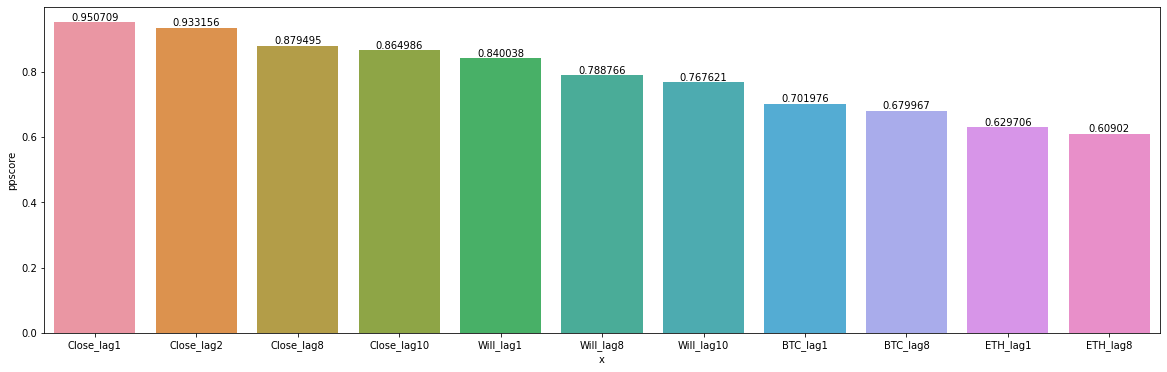

In [72]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_shifted1000_raw, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

Hormis pour ETH qui est le dernier des pps, il y a une perte globale de -0.1 à -0.6 pour tous les autres.<br>
En l'occurrence, <b>La conversion en base 1000 n'apporte aucun intérêt comparativement à un shift des valeurs brutes</b>

# Comparaison des pps & correlation en cible catégorielle
Plutôt que de tenter de prédire la valeur de la cloture avec la MAE, on va tenter de prédire l'appartenance à une fourchette de valeurs qui nous intéresse

In [73]:
df_agg.head()

Date    Close  BAMLC0A0CMEY  BAMLC0A0CM  BAMLH0A0HYM2  BAMLH0A3HYCEY  \
0 2013-03-01  2747.75          2.79        1.49          5.00           9.65   
1 2013-03-04  2759.53          2.80        1.49          4.98           9.64   
2 2013-03-05  2799.25          2.80        1.48          4.92           9.56   
3 2013-03-06  2792.56          2.83        1.47          4.88           9.53   
4 2013-03-07  2799.49          2.86        1.46          4.81           9.49   

   CBBTCUSD  CBETHUSD  DAAA  DEXUSEU  GVZCLS  RVXCLS  T10Y2Y  VIXCLS  VXDCLS  \
0       NaN       NaN  3.83   1.2988   15.75   18.33    1.61   15.36   13.61   
1       NaN       NaN  3.85   1.2996   16.03   17.96    1.64   14.01   12.77   
2       NaN       NaN  3.87   1.3019   15.47   16.82    1.65   13.48   12.38   
3       NaN       NaN  3.91   1.2990   15.05   16.65    1.70   13.53   12.44   
4       NaN       NaN  3.96   1.3098   14.84   16.14    1.75   13.06   12.04   

   VXNCLS  WILL5000PR  
0   15.64    15738.23  
1   15.39    15807.78  
2   14.60    15961.95  
3   14.60    15982.29  
4   14.23    16020.51

On va faire les catégories suivantes à +3j, +5j et +10j
<li> [inf ; -5%[ strong sell</li>
<li> [-5% ; -2%[ sell </li>
<li> [-2% ; 2%[ range (incluant frais transaction) </li>
<li> [2% ; 5%[ buy </li>
<li> [2% ; inf[ strong buy</li>


In [80]:
df_categories = df_agg.copy()

In [81]:
df_categories["vClose_3d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(3))*100, 2)
df_categories["vClose_5d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(5))*100, 2)
df_categories["vClose_8d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(8))*100, 2)
df_categories["vClose_13d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(13))*100, 2)

array([[<AxesSubplot:title={'center':'vClose_3d'}>,
        <AxesSubplot:title={'center':'vClose_5d'}>],
       [<AxesSubplot:title={'center':'vClose_8d'}>,
        <AxesSubplot:title={'center':'vClose_13d'}>]], dtype=object)

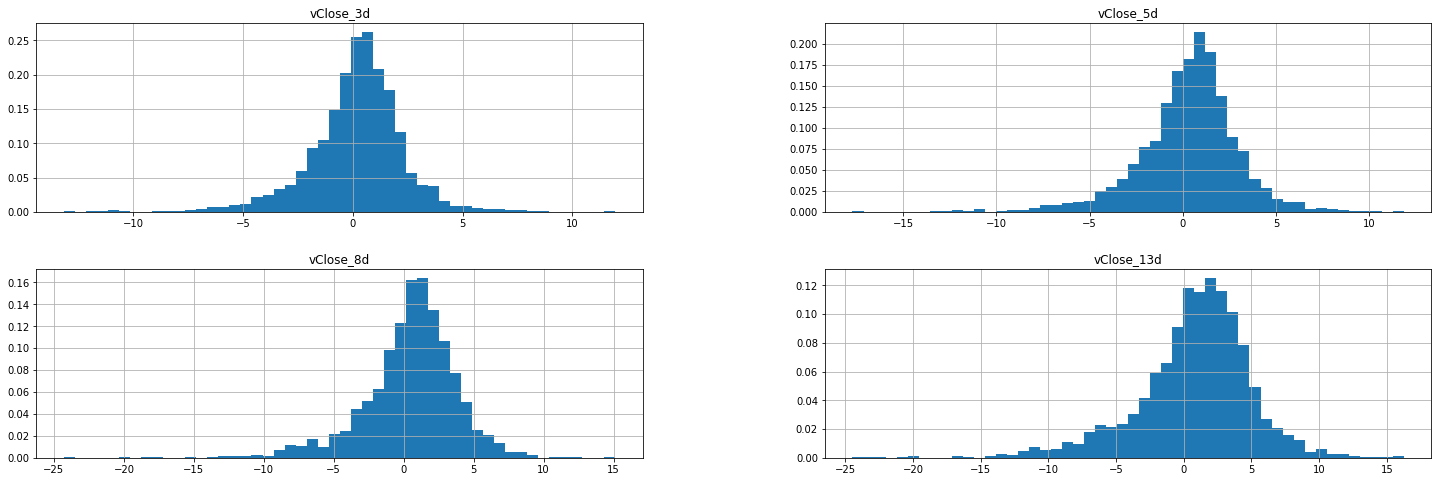

In [82]:
df_categories[["vClose_3d","vClose_5d","vClose_8d","vClose_13d"]].hist(figsize=(25,8),bins=50, density=True)

In [83]:
df_categories[["vClose_3d","vClose_5d","vClose_8d","vClose_13d"]].describe()

vClose_3d    vClose_5d   vClose_8d   vClose_13d
count  2538.000000  2536.000000  2533.00000  2528.000000
mean      0.173692     0.289397     0.46473     0.761503
std       2.164814     2.724910     3.38963     4.249388
min     -13.140000   -17.720000   -24.28000   -24.470000
25%      -0.810000    -0.980000    -1.06000    -1.242500
50%       0.340000     0.560000     0.83000     1.265000
75%       1.380000     1.802500     2.44000     3.342500
max      11.960000    11.860000    15.13000    16.260000

In [95]:
#bins = pd.IntervalIndex.from_tuples([(-30, -5), (-5, -2), (-2, 2), (2, 5), (5, 30)])
bins = [-30, -5, -2, 2, 5, 30]
labels = ["strong sell","sell","range","buy","strong buy"]

In [98]:
df_categories["catClose_3d"] = pd.cut(df_categories["vClose_3d"].to_numpy(), bins, labels=labels)
df_categories["catClose_5d"] = pd.cut(df_categories["vClose_5d"].to_numpy(), bins, labels=labels)
df_categories["catClose_8d"] = pd.cut(df_categories["vClose_8d"].to_numpy(), bins, labels=labels)
df_categories["catClose_13d"] = pd.cut(df_categories["vClose_13d"].to_numpy(), bins, labels=labels)

In [99]:
df_categories["catClose_3d"].value_counts().sort_index()

strong sell      53
sell            263
range          1863
buy             320
strong buy       39
Name: catClose_3d, dtype: int64

In [100]:
df_categories["catClose_13d"].value_counts().sort_index()

strong sell     237
sell            263
range          1000
buy             750
strong buy      278
Name: catClose_13d, dtype: int64